In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
path = '/dados/das/pesq1/BAM.berror/xc50/old/'

#file = 'gsir4.berror_stats.gcv.BAM.TQ0062L028'
#file = 'gsir4.berror_stats.gcv.BAM.TQ0254L064'
#file = 'gsir4.berror_stats.gcv.BAM.TQ0299L064'
#file = 'gsir4.berror_stats.gcv'
bcptec = 'new_gsir4.berror_stats-tese-cfbastarz2017.gcv'
bncep = 'global_berror.l64y386.f77-ncep-dtc.gcv'

fncep = os.path.join(path, bncep)
fcptec = os.path.join(path, bcptec)

In [3]:
class Berror:
    
    def __init__(self, file_name):
        self.file_name = file_name
    
    def read_records(self):
        # Lê os três primeiros records para definir a grade
        dt = np.dtype([ ('grid', '3>i4') ])

        with open(self.file_name, 'rb') as ftmp:
            fobj = np.fromfile(ftmp, dtype=dt, count=3, offset=4)  
        
        nsig = fobj[0]['grid'][0]
        nlat = fobj[0]['grid'][1]
        nlon = fobj[0]['grid'][2]
       
        self.nlat = nlat
        self.nlon = nlon
        self.nsig = nsig
    
        self.lats = np.linspace(-90,90, self.nlat)
        self.lons = np.linspace(0,360, self.nlon)
        self.levs = np.arange(1, self.nsig+1)
        
        # Define os tamanhos dos records dentro do arquivo ('>f4' indica floats de 32 bits, big endian)   
        tnlat = str(self.nlat) + '>f4'
        s2d = str(self.nlat*self.nsig) + '>f4'
        sst2d = str(self.nlat*self.nlon) + '>f4'
        s3d = str(self.nlat*self.nsig*self.nsig) + '>f4'

        # Define a estrutura e o tamanho do records dentro do arquivo    
        dt =          [ ('grid', '3>i4'), 
                   
                        ('pad1', '>i4'), ('agvin',s3d), 
                        ('pad2', '>i4'), ('bgvin', s2d),
                        ('pad3', '>i4'), ('wgvin', s2d), 
                       
                        ('pad4', '>i4'), ('sf', '|a5'), ('sig_sf', '>i4'), ('pad5', '>i4'), 
                        ('pad6', '>i4'), ('corzin_sf', s2d), ('pad7', '>i4'), 
                        ('pad8', '>i4'), ('hscalesin_sf', s2d), ('pad9', '>i4'), 
                        ('pad10', '>i4'), ('vscalesin_sf', s2d), ('pad11', '>i4'), 
                   
                        ('pad12', '>i4'), ('vp', '|a5'), ('sig_vp', '>i4'), ('pad13', '>i4'),
                        ('pad14', '>i4'), ('corzin_vp', s2d), ('pad15', '>i4'), 
                        ('pad16', '>i4'), ('hscalesin_vp', s2d), ('pad17', '>i4'), 
                        ('pad18', '>i4'), ('vscalesin_vp', s2d), ('pad19', '>i4'), 
                   
                        ('pad20', '>i4'), ('t', '|a5'), ('sig_t', '>i4'), ('pad21', '>i4'),
                        ('pad22', '>i4'), ('corzin_t', s2d), ('pad23', '>i4'), 
                        ('pad24', '>i4'), ('hscalesin_t', s2d), ('pad25', '>i4'), 
                        ('pad26', '>i4'), ('vscalesin_t', s2d), ('pad27', '>i4'), 
                   
                        ('pad28', '>i4'), ('q', '|a5'), ('sig_q', '>i4'), ('pad29', '>i4'),
                        ('pad30', '>i4'), ('corzin_q', s2d), ('corqin_q', s2d), ('pad31', '>i4'), 
                        ('pad32', '>i4'), ('hscalesin_q', s2d), ('pad33', '>i4'), 
                        ('pad34', '>i4'), ('vscalesin_q', s2d), ('pad35', '>i4'), 
                   
                        ('pad36', '>i4'), ('oz', '|a5'), ('sig_oz', '>i4'), ('pad37', '>i4'),
                        ('pad38', '>i4'), ('corzin_oz', s2d), ('pad39', '>i4'), 
                        ('pad40', '>i4'), ('hscalesin_oz', s2d), ('pad41', '>i4'), 
                        ('pad42', '>i4'), ('vscalesin_oz', s2d), ('pad43', '>i4'), 
                                      
                        ('pad44', '>i4'), ('cw', '|a5'), ('sig_cw', '>i4'), ('pad45', '>i4'),
                        ('pad46', '>i4'), ('corzin_cw', s2d), ('pad47', '>i4'), 
                        ('pad48', '>i4'), ('hscalesin_cw', s2d), ('pad49', '>i4'), 
                        ('pad50', '>i4'), ('vscalesin_cw', s2d), ('pad51', '>i4'), 
                   
                        ('pad52', '>i4'), ('ps', '|a5'), ('sig_ps', '>i4'), ('pad53', '>i4'), 
                        ('pad54', '>i4'), ('corpin_ps', tnlat), ('pad55', '>i4'), 
                        ('pad56', '>i4'), ('hscalespin_ps', tnlat), ('pad57', '>i4'), 
                   
                        ('pad58', '>i4'), ('sst', '|a5'), ('sig_sst', '>i4'), ('pad59', '>i4'),
                        ('pad60', '>i4'), ('corsstin_sst', sst2d), ('pad61', '>i4'), 
                        ('pad62', '>i4'), ('hsstin_ps', sst2d), ('pad63', '>i4') ]   
    
        dt_obj = np.dtype(dt)#, align=True)
    
        with open(self.file_name, 'rb') as ftmp:
            fobj = np.fromfile(ftmp, dtype=dt_obj, count=-1, offset=4) # count=-1 lê todo o arquivo
    
        # Matrizes de Projeção  
        
        balprojs = {}
    
        self.balprojs = balprojs
    
        agvin = np.reshape(fobj[0]['agvin'], (self.nlat, self.nsig, self.nsig), order='F')
        da_agvin = xr.DataArray(agvin, dims=['latitude', 'sigma', 'sigma_2'], coords={'latitude':self.lats, 'sigma':self.levs, 'sigma_2':self.levs})
        da_agvin = da_agvin.transpose('sigma', 'latitude', 'sigma_2')
        da_agvin = da_agvin.rename('agvin')

        balprojs['agvin'] = da_agvin
    
        bgvin = np.reshape(fobj[0]['bgvin'], (self.nlat, self.nsig), order='F')
        da_bgvin = xr.DataArray(bgvin, dims=['latitude', 'sigma'], coords={'latitude':self.lats, 'sigma':self.levs})
        da_bgvin = da_bgvin.transpose('sigma', 'latitude')
        da_bgvin = da_bgvin.rename('bgvin')

        balprojs['bgvin'] = da_bgvin
    
        wgvin = np.reshape(fobj[0]['wgvin'], (self.nlat, self.nsig), order='F')
        da_wgvin = xr.DataArray(wgvin, dims=['latitude', 'sigma'], coords={'latitude':self.lats, 'sigma':self.levs})
        da_wgvin = da_wgvin.transpose('sigma', 'latitude')
        da_wgvin = da_wgvin.rename('wgvin')
    
        balprojs['wgvin'] = da_wgvin      
        
        # Amplitudes
        
        amplitudes = {}
        
        self.amplitudes = amplitudes
        
        amplitudes_names = {
            'sf':  'corzin_sf', 
            'vp':  'corzin_vp', 
            't':   'corzin_t', 
            'q':   'corzin_q', 
            'qin': 'corqin_q',
            'oz':  'corzin_oz', 
            'ps':  'corpin_ps', 
            'cw':  'corzin_cw', 
            'sst': 'corsstin_sst',
        }
        
        self.amplitudes_names = amplitudes_names
        
        for var in amplitudes_names.items():
            if var[0] == 'ps':
                corzin_var = np.reshape(fobj[0][var[1]], (self.nlat), order='F')
                da_corzin_var = xr.DataArray(corzin_var, dims=['latitude'], coords={'latitude':self.lats})
            elif var[0] == 'sst':
                corzin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nlon), order='F')
                da_corzin_var = xr.DataArray(corzin_var, dims=['latitude', 'longitude'], coords={'latitude':self.lats, 'longitude':self.lons})
            else:
                corzin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nsig), order='F')
                da_corzin_var = xr.DataArray(corzin_var, dims=['latitude', 'sigma'], coords={'latitude':self.lats, 'sigma':self.levs})
                da_corzin_var = da_corzin_var.transpose('sigma', 'latitude')
            
            da_corzin_var = da_corzin_var.rename(var[1])
        
            amplitudes[var[0]] = da_corzin_var
        
        # Comprimentos de escala horizontais
        
        hscales = {}
        
        self.hscales = hscales
        
        hscales_var_names = {
            'sf':  'hscalesin_sf', 
            'vp':  'hscalesin_vp', 
            't':   'hscalesin_t', 
            'q':   'hscalesin_q', 
            'oz':  'hscalesin_oz', 
            'ps':  'hscalespin_ps', 
            'cw':  'hscalesin_cw', 
            'sst': 'hsstin_ps',
        }        
        
        self.hscales_var_names = hscales_var_names
        
        for var in hscales_var_names.items():
            if var[0] == 'ps':
                hscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat), order='F')
                da_hscalesin_var = xr.DataArray(hscalesin_var, dims=['latitude'], coords={'latitude':self.lats})
            elif var[0] == 'sst':
                hscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nlon), order='F')
                da_hscalesin_var = xr.DataArray(hscalesin_var, dims=['latitude', 'longitude'], coords={'latitude':self.lats, 'longitude':self.lons})
            else:
                hscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nsig), order='F')
                da_hscalesin_var = xr.DataArray(hscalesin_var, dims=['latitude', 'sigma'], coords={'latitude':self.lats, 'sigma':self.levs})
                da_hscalesin_var = da_hscalesin_var.transpose('sigma', 'latitude')
            
            da_hscalesin_var = da_hscalesin_var.rename(var[1])
        
            hscales[var[0]] = da_hscalesin_var           
        
        # Comprimentos de escala verticais
        
        vscales = {}
        
        self.vscales = vscales

        vscales_var_names = {
            'sf':  'vscalesin_sf', 
            'vp':  'vscalesin_vp', 
            't':   'vscalesin_t', 
            'q':   'vscalesin_q', 
            'oz':  'vscalesin_oz',  
            'cw':  'vscalesin_cw', 
        }         
        
        self.vscales_var_names = vscales_var_names
        
        for var in vscales_var_names.items():
            if var[0] == 'ps':
                vscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat), order='F')
                da_vscalesin_var = xr.DataArray(vscalesin_var, dims=['latitude'], coords={'latitude':self.lats})
            elif var[0] == 'sst':
                vscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nlon), order='F')
                da_vscalesin_var = xr.DataArray(vscalesin_var, dims=['latitude', 'longitude'], coords={'latitude':self.lats, 'longitude':self.lons})
            else:
                vscalesin_var = np.reshape(fobj[0][var[1]], (self.nlat, self.nsig), order='F')
                da_vscalesin_var = xr.DataArray(vscalesin_var, dims=['latitude', 'sigma'], coords={'latitude':self.lats, 'sigma':self.levs})
                da_vscalesin_var = da_vscalesin_var.transpose('sigma', 'latitude')
            
            da_vscalesin_var = da_vscalesin_var.rename(var[1])
        
            vscales[var[0]] = da_vscalesin_var

In [4]:
ncep_b = Berror(fncep)
cptec_b = Berror(fcptec)

In [5]:
ncep_b.read_records()
cptec_b.read_records()

In [6]:
ncep_b.nlat, ncep_b.nlon, ncep_b.nsig

(386, 768, 64)

In [7]:
cptec_b.nlat, cptec_b.nlon, cptec_b.nsig

(98, 192, 28)

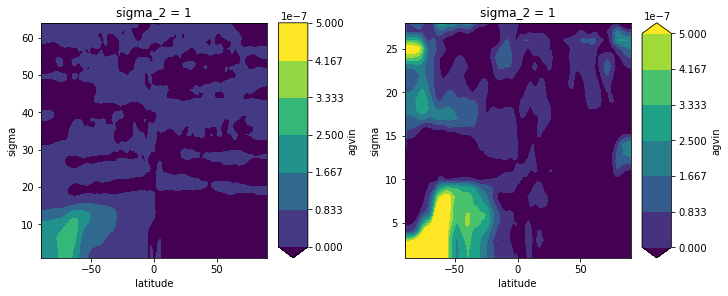

In [8]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.balprojs['agvin'].isel(sigma_2=0).plot.contourf(ax=ax[0], vmin=0, vmax=5e-7)
cptec_b.balprojs['agvin'].isel(sigma_2=0).plot.contourf(ax=ax[1], vmin=0, vmax=5e-7)

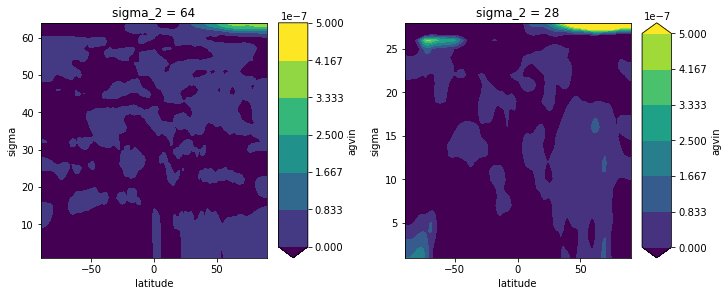

In [10]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.balprojs['agvin'].isel(sigma_2=-1).plot.contourf(ax=ax[0], vmin=0, vmax=5e-7)
cptec_b.balprojs['agvin'].isel(sigma_2=-1).plot.contourf(ax=ax[1], vmin=0, vmax=5e-7)

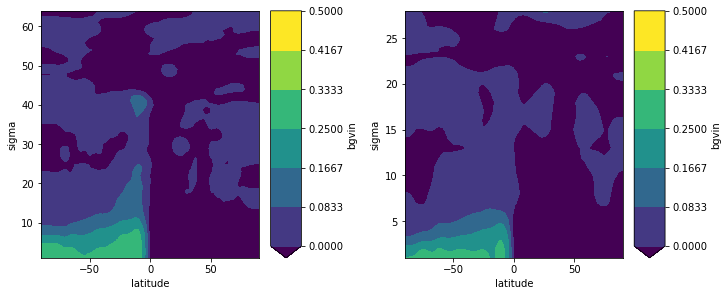

In [11]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.balprojs['bgvin'].plot.contourf(ax=ax[0], vmin=0, vmax=0.5)
cptec_b.balprojs['bgvin'].plot.contourf(ax=ax[1], vmin=0, vmax=0.5)

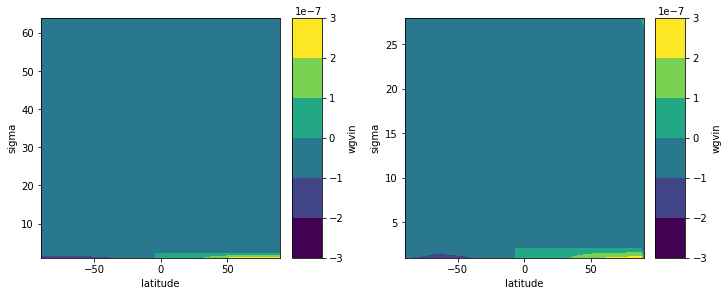

In [12]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.balprojs['wgvin'].plot.contourf(ax=ax[0], vmin=-3e-7, vmax=3e-7)
cptec_b.balprojs['wgvin'].plot.contourf(ax=ax[1], vmin=-3e-7, vmax=3e-7)

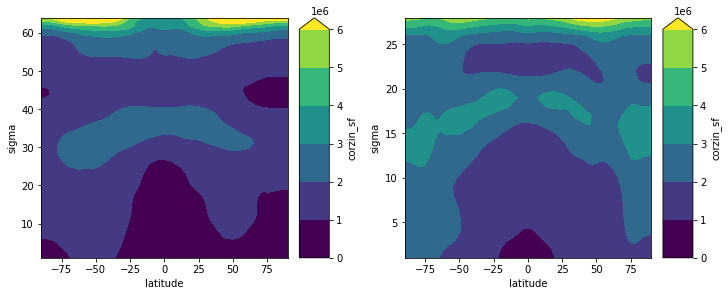

In [13]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['sf'].plot.contourf(ax=ax[0], vmin=0, vmax=6e6)
cptec_b.amplitudes['sf'].plot.contourf(ax=ax[1], vmin=0, vmax=6e6)

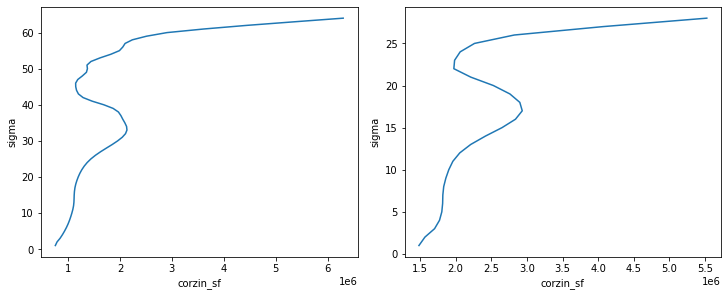

In [19]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['sf'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['sf'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

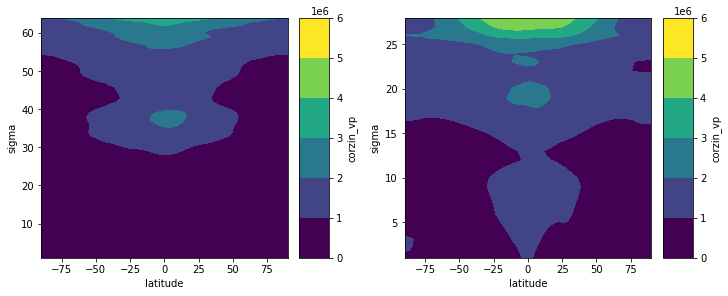

In [20]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['vp'].plot.contourf(ax=ax[0], vmin=0, vmax=6e6)
cptec_b.amplitudes['vp'].plot.contourf(ax=ax[1], vmin=0, vmax=6e6)

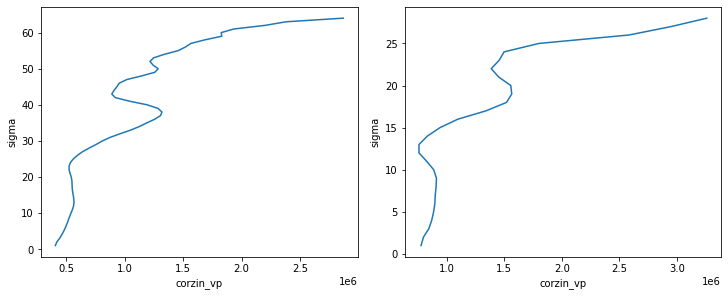

In [21]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['vp'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['vp'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

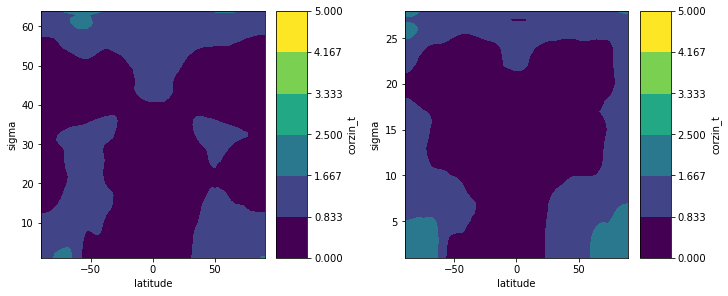

In [22]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['t'].plot.contourf(ax=ax[0], vmin=0, vmax=5)
cptec_b.amplitudes['t'].plot.contourf(ax=ax[1], vmin=0, vmax=5)

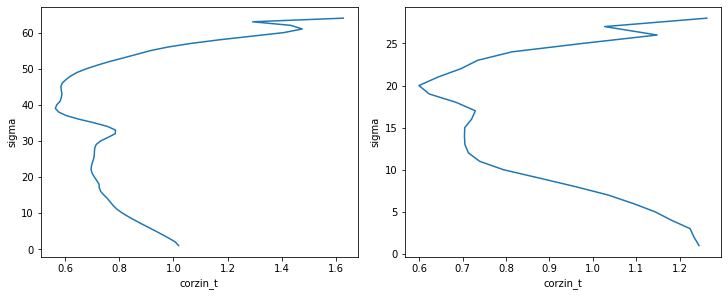

In [23]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['t'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['t'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

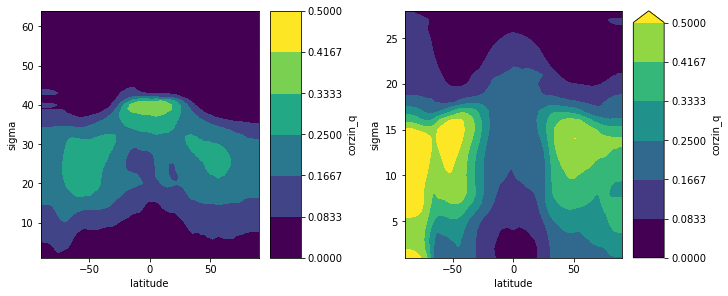

In [24]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['q'].plot.contourf(ax=ax[0], vmin=0, vmax=0.5)
cptec_b.amplitudes['q'].plot.contourf(ax=ax[1], vmin=0, vmax=0.5)

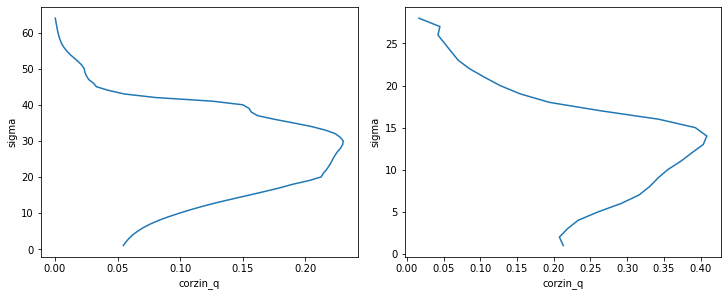

In [25]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['q'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['q'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

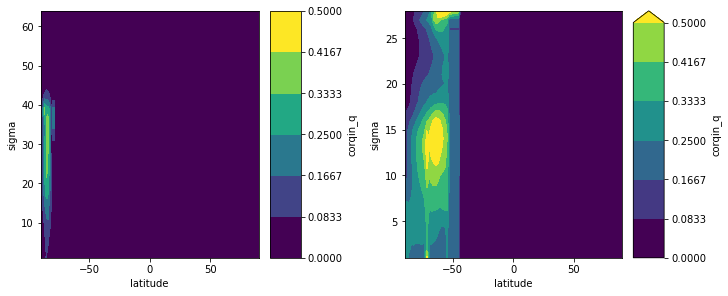

In [26]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['qin'].plot.contourf(ax=ax[0], vmin=0, vmax=0.5)
cptec_b.amplitudes['qin'].plot.contourf(ax=ax[1], vmin=0, vmax=0.5)

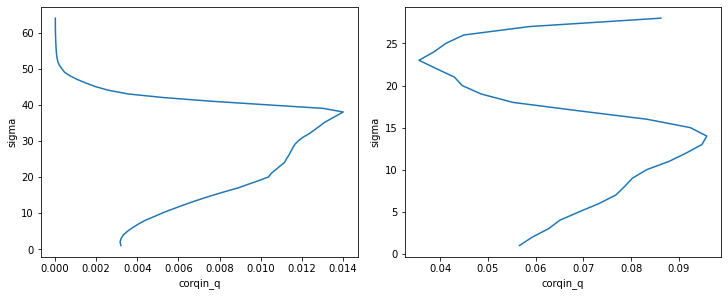

In [27]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['qin'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['qin'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

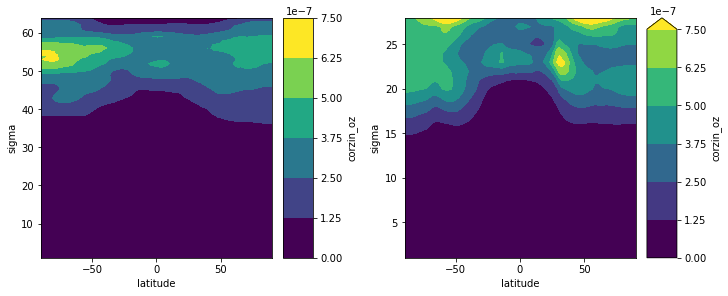

In [28]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['oz'].plot.contourf(ax=ax[0], vmin=0, vmax=7.5e-7)
cptec_b.amplitudes['oz'].plot.contourf(ax=ax[1], vmin=0, vmax=7.5e-7)

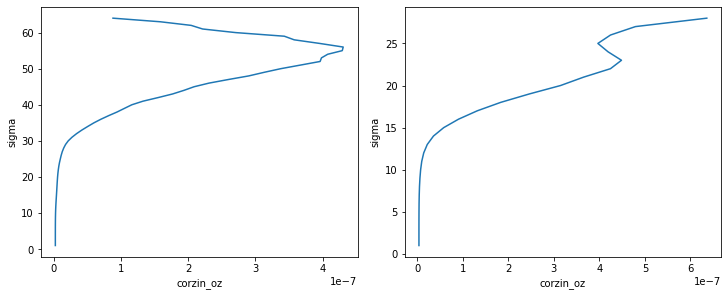

In [29]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['oz'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['oz'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

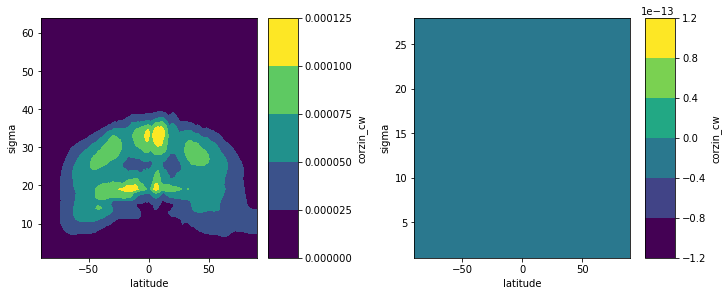

In [30]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['cw'].plot.contourf(ax=ax[0])#, vmin=0, vmax=7.5e-7)
cptec_b.amplitudes['cw'].plot.contourf(ax=ax[1])#, vmin=0, vmax=7.5e-7)

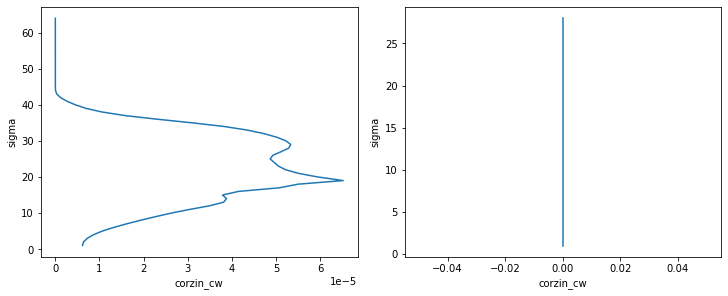

In [31]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['cw'].mean(dim='latitude').plot(ax=ax[0], y='sigma')
cptec_b.amplitudes['cw'].mean(dim='latitude').plot(ax=ax[1], y='sigma')

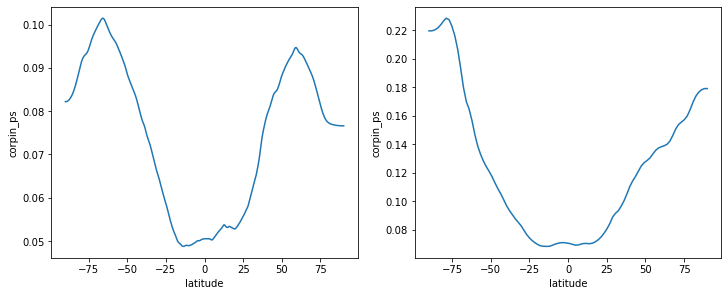

In [32]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.amplitudes['ps'].plot(ax=ax[0])#, vmin=0, vmax=0.2)
cptec_b.amplitudes['ps'].plot(ax=ax[1])#, vmin=0, vmax=0.2)

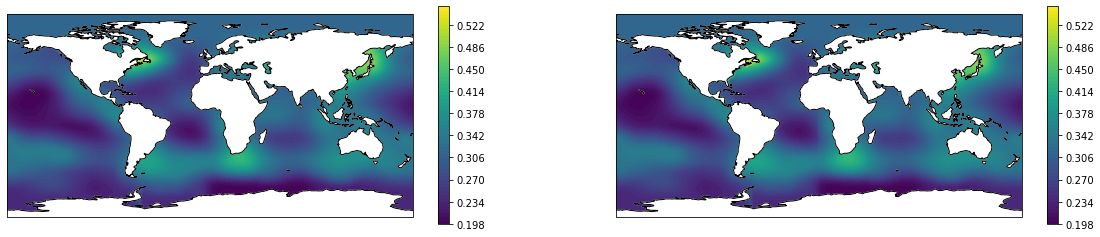

In [33]:
plt.figure(figsize=(20,4))#, constrained_layout=True)

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='white'))
obj1 = ax1.contourf(ncep_b.lons, ncep_b.lats, ncep_b.amplitudes['sst'], 60, transform=ccrs.PlateCarree())
plt.colorbar(obj1)
ax1.coastlines()

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='white'))
obj2 = ax2.contourf(cptec_b.lons, cptec_b.lats, cptec_b.amplitudes['sst'], 60, transform=ccrs.PlateCarree())
plt.colorbar(obj2)
ax2.coastlines()

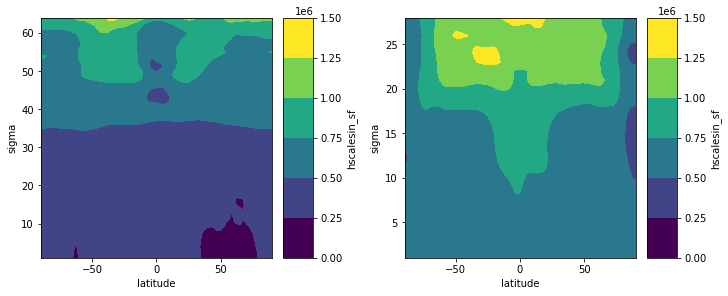

In [34]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['sf'].plot.contourf(ax=ax[0], vmin=0, vmax=1.5e6)
cptec_b.hscales['sf'].plot.contourf(ax=ax[1], vmin=0, vmax=1.5e6)

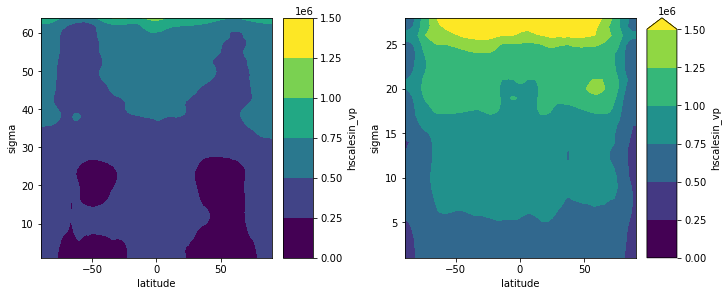

In [35]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['vp'].plot.contourf(ax=ax[0], vmin=0, vmax=1.5e6)
cptec_b.hscales['vp'].plot.contourf(ax=ax[1], vmin=0, vmax=1.5e6)

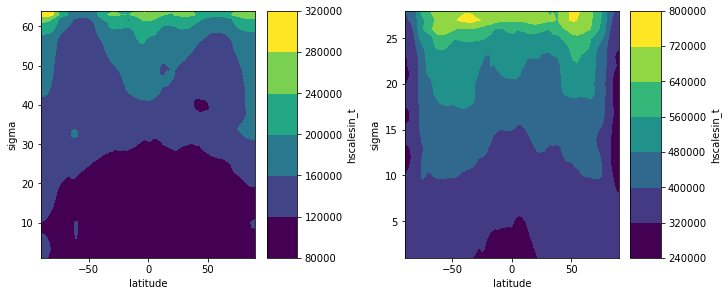

In [36]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['t'].plot.contourf(ax=ax[0])#, vmin=0, vmax=3.5e5)
cptec_b.hscales['t'].plot.contourf(ax=ax[1])#, vmin=0, vmax=3.5e5)

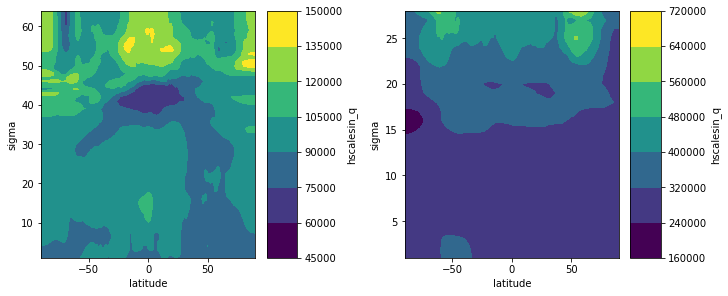

In [37]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['q'].plot.contourf(ax=ax[0])#, vmin=0, vmax=1.5e5)
cptec_b.hscales['q'].plot.contourf(ax=ax[1])#, vmin=0, vmax=1.5e5)

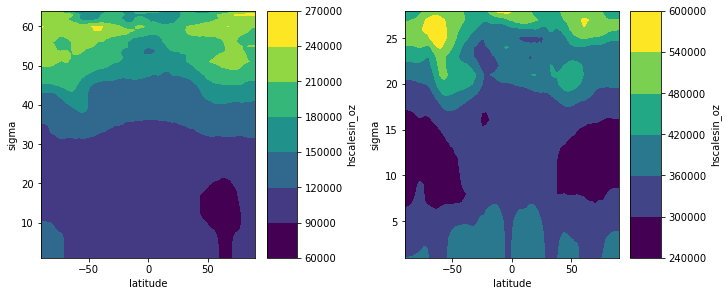

In [38]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['oz'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.hscales['oz'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

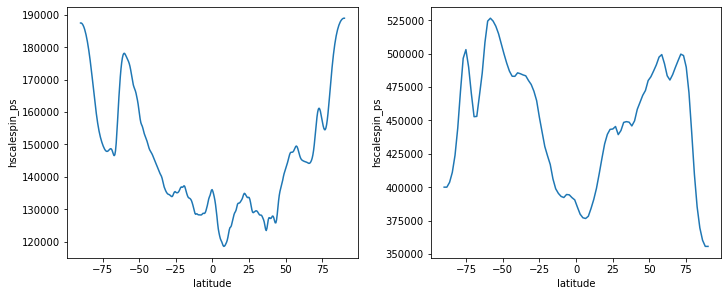

In [39]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.hscales['ps'].plot(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.hscales['ps'].plot(ax=ax[1])#, vmin=0, vmax=2.5e5)

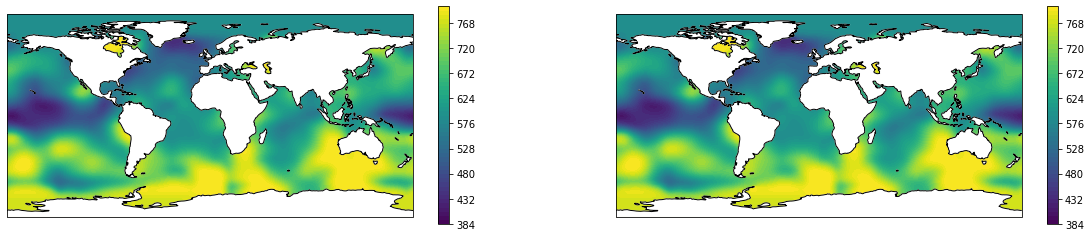

In [40]:
plt.figure(figsize=(20,4))#, constrained_layout=True)

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='white'))
obj1 = ax1.contourf(ncep_b.lons, ncep_b.lats, ncep_b.hscales['sst'], 60, transform=ccrs.PlateCarree())
plt.colorbar(obj1)
ax1.coastlines()

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='white'))
obj2 = ax2.contourf(cptec_b.lons, cptec_b.lats, cptec_b.hscales['sst'], 60, transform=ccrs.PlateCarree())
plt.colorbar(obj2)
ax2.coastlines()

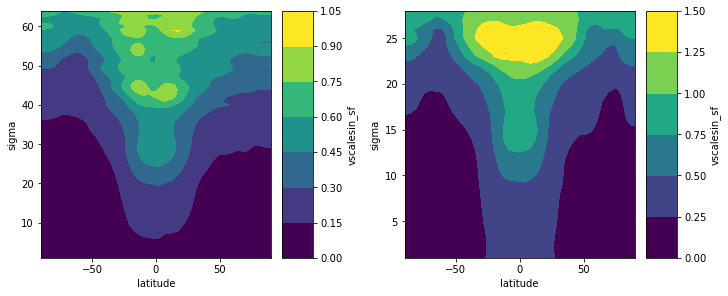

In [41]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['sf'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['sf'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

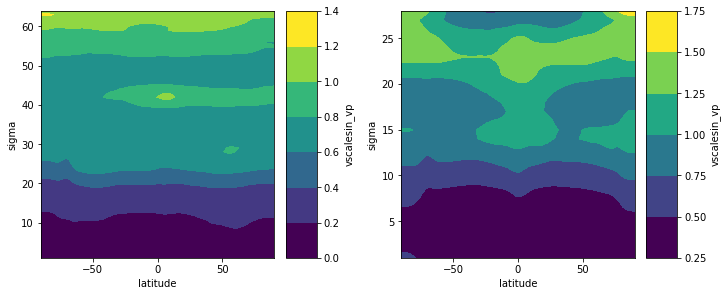

In [42]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['vp'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['vp'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

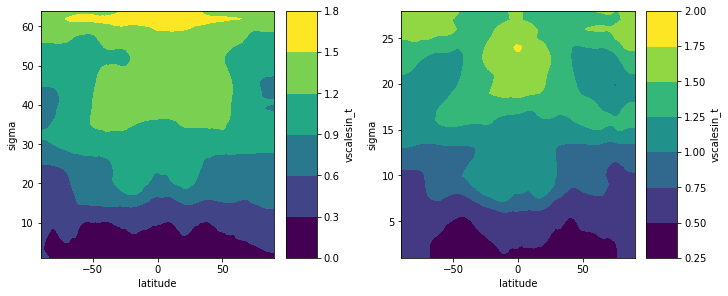

In [43]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['t'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['t'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

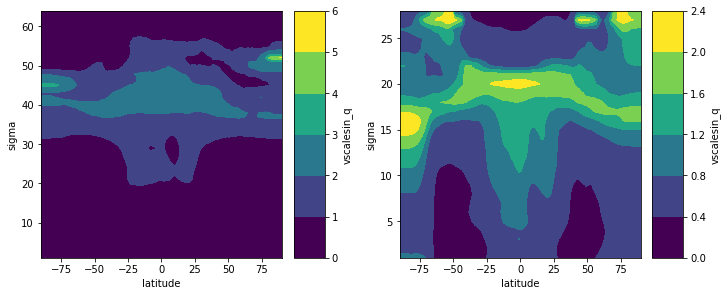

In [44]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['q'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['q'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

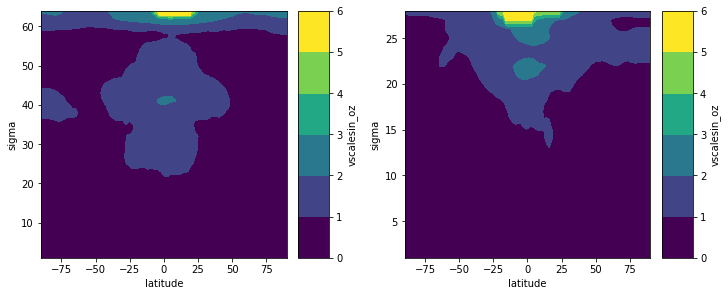

In [45]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['oz'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['oz'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)

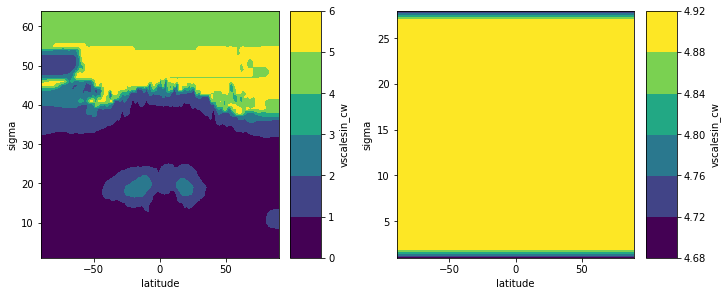

In [46]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ncep_b.vscales['cw'].plot.contourf(ax=ax[0])#, vmin=0, vmax=2.5e5)
cptec_b.vscales['cw'].plot.contourf(ax=ax[1])#, vmin=0, vmax=2.5e5)